In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import warnings 
warnings.filterwarnings(action='ignore')

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,CondensedNearestNeighbour,EditedNearestNeighbours

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [4]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props #, NAlist

In [5]:
data1 = pd.read_csv('MEASURED_WAVE_TRAIN.csv',encoding='cp949')
df1 =  pd.DataFrame(data1.MEASURED_WAVE.str.split(',').tolist()) # 콤마 제거 이후 열 형태로 변경
df1.columns = 'MEASURED_WAVE_' + df1.columns.astype(str)
data1 = pd.concat([data1[['REFERENCE_ID','QUALITY']],df1],axis=1)

data2 = pd.read_csv('REFERENCE_WAVE.csv',encoding='cp949')
df2 =  pd.DataFrame(data2.REFERENCE_WAVE.str.split(',').tolist()) # 콤마 제거 이후 열 형태로 변경 
df2.columns = 'REFERENCE_WAVE_' + df2.columns.astype(str)
data2 = pd.concat([data2[['REFERENCE_ID']],df2],axis=1)


for col in data1.columns:

            try : data1[col] = data1[col].astype('float')
            except: pass     
            
            
for col in data2.columns:

            try : data2[col] = data2[col].astype('float')
            except: pass  
            
data_full = pd.merge(data1,data2,how='left',on = 'REFERENCE_ID').dropna()
data_full['QUALITY'] = data_full['QUALITY'].replace({'GOOD':0,'BAD':1})

In [6]:
data_full.shape

(27176, 402)

In [7]:
data_full['QUALITY'].value_counts()

QUALITY
0    25838
1     1338
Name: count, dtype: int64

In [8]:
data_full = reduce_mem_usage(data_full)

Memory usage of properties dataframe is : 83.349365234375  MB
******************************
Column:  QUALITY
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  MEASURED_WAVE_0
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  MEASURED_WAVE_1
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  MEASURED_WAVE_2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  MEASURED_WAVE_3
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  MEASURED_WAVE_4
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  MEASURED_WAVE_5
dtype before:  float64
dtype after:  uint16
******************************
******************************
C

dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_142
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_143
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_144
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_145
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_146
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_147
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  REFERENCE_WAVE_148
dtype before:  float64
dtype after:  uint16
******************************
**********

In [9]:
Feature_Selection = True

In [10]:
def Train_Test_Split(Feature_Selection):
    
    Data = data_full
    Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)
    
    X = Input_Data
    y = Data['QUALITY']
    
    if Feature_Selection == False:

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test
    
    if Feature_Selection == True:
        
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
        Train = pd.concat([X_train,y_train],axis=1)
        Pass = Train[Train['QUALITY']==0].drop(['QUALITY'],axis=1)
        Fail = Train[Train['QUALITY']==1].drop(['QUALITY'],axis=1)

        T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
        Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
        P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
        Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

        Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
        df_ttest = Data[Significant_Values]

        X_train,X_test,y_train,y_test = train_test_split(df_ttest,y,test_size=0.2,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test 
    
X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
X_train.shape, X_test.shape

((21740, 86), (564, 86))

In [11]:
y_train.value_counts(),y_test.value_counts()

(QUALITY
 0    20653
 1     1087
 Name: count, dtype: int64,
 QUALITY
 0    313
 1    251
 Name: count, dtype: int64)

In [12]:
# T-Test & Top10 Corr Feature Selection

Train_Features = pd.concat([X_train,y_train],axis=1)
df_corr =Train_Features.corr().iloc[1:,-1]
df_corr = pd.DataFrame(df_corr).rename(columns={'QUALITY':'Corr'}).abs().reset_index()
df_corr = df_corr.sort_values(by='Corr',ascending = False).iloc[1:]
Top10_Corr = df_corr.head(10)['index'].to_list()

#X_train = X_train[Top10_Corr]
#X_test = X_test[Top10_Corr]

#X_train.shape, X_test.shape

In [13]:
#### Corr Feature Selection

#Data = data_full
#Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)

#X = Input_Data
#y = Data['QUALITY']

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
#Train = pd.concat([X_train,y_train],axis=1)

#df_corr = Train.corr().iloc[1:,-1]
#df_corr = pd.DataFrame(df_corr).rename(columns={'QUALITY':'Corr'}).abs().reset_index()
#df_corr = df_corr.sort_values(by='Corr',ascending = False).iloc[1:]
#df_corr = df_corr[df_corr['Corr'] >= 0.2] # 데이터마다 상관계수 최소값 다름 
#Corr_Values = df_corr['index'].to_list()

#df_Corr = Data[Corr_Values]
#X_train,X_test,y_train,y_test = train_test_split(df_Corr,y,test_size=0.2,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

#X_train.shape,X_test.shape

In [14]:
#### VIF Feature Selection

#Data = data_full
#Input_Data = data_full.drop(['REFERENCE_ID','QUALITY'],axis=1)

#X = Input_Data
#y = Data['QUALITY']
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
#Train = pd.concat([X_train,y_train],axis=1)

#X = Train.drop(['QUALITY'],axis=1)
#scaler = StandardScaler()
#scale_cols =  X.columns
#scaled_X = scaler.fit_transform(X[scale_cols])
#scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
#scaled_X = scaled_X.set_index(X.index)

#vif = pd.DataFrame()
#vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                     #for i in range(scaled_X.shape[1])]
#X_Columns = pd.DataFrame(scaled_X.columns).rename(columns={0:'Columns'})

#df_vif = pd.concat([X_Columns,vif],axis=1)
#df_VIF = Data[df_vif[df_vif['VIF_Factor'] <= 10]['Columns'].to_list()]

#X_train,X_test,y_train,y_test = train_test_split(df_VIF,y,test_size=0.1,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

In [15]:
# 활용할 ML 나열 
rf = RandomForestClassifier(random_state=2021)
rf_bal = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021)
xgb_bal = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgbm =  LGBMClassifier(random_state=2021)
lgbm_bal = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]) 

models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [16]:
def test_model(model):
        
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('----------------------------------------------------------------------------------------------------------')
    get_clf_eval(y_test,pred,pred_proba)  
    print('\n')
    print(classification_report(y_test, pred,target_names=['양품','불량']))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == rf_bal:
        print('RandomForest(Balanced Weight) Prediction Result')
        print('\n')  
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == xgb_bal:
        print('XGBoost(Balanced Weight) Prediction Result')
        print('\n')    
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
    elif model == lgbm_bal:
        print('LightGBM(Balanced Weight) Prediction Result')

In [17]:
test_model(models[7]) 

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[306   7]
 [ 53 198]]


정확도: 0.894 정밀도: 0.966 재현율: 0.789 AUC: 0.97 F1: 0.868 F2: 0.819 Balanced_Accuracy: 0.883


              precision    recall  f1-score   support

          양품       0.85      0.98      0.91       313
          불량       0.97      0.79      0.87       251

    accuracy                           0.89       564
   macro avg       0.91      0.88      0.89       564
weighted avg       0.90      0.89      0.89       564

LightGBM(Balanced Weight) Prediction Result


In [18]:
# 전체 모델  원큐 출력 
#for i in range(0,len(models)):

#    model = models[i]
#    test_model(model) 

In [19]:
def Oversampling_Test(model):
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        oversampler = SMOTEENN(sampling_strategy=i,random_state=2021)
        X_train_over,y_train_over = oversampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_over,y_train_over) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   

        elif model == ada:
            print('AdaBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [20]:
#Oversampling_Test(models[0])

In [21]:
#Oversampling_Test(models[1])

In [22]:
#Oversampling_Test(models[2])

In [23]:
#Oversampling_Test(models[3])

In [24]:
#Oversampling_Test(models[4])

In [25]:
#Oversampling_Test(models[5])

In [26]:
#Oversampling_Test(models[6])

In [27]:
#Oversampling_Test(models[7])

In [28]:
def Undersampling_Test(model):
     
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        undersampler = RandomUnderSampler(sampling_strategy=i,random_state=2021) 
        #undersampler = NearMiss() --> ROS 이외의 언더샘플링 진행시 for 반복문 해제 
        # TomekLink(), NearMiss, EditedNearestNeigbours,CondensedNearestNeighbour
        
        X_train_under,y_train_under = undersampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_under,y_train_under) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [29]:
#Undersampling_Test(models[0])

In [30]:
Undersampling_Test(models[1])

Confusion Matrix
[[295  18]
 [ 45 206]]


정확도: 0.888 정밀도: 0.92 재현율: 0.821 AUC: 0.962 F1: 0.867 F2: 0.839 Balanced_Accuracy: 0.882


              precision    recall  f1-score   support

          양품       0.87      0.94      0.90       313
          불량       0.92      0.82      0.87       251

    accuracy                           0.89       564
   macro avg       0.89      0.88      0.89       564
weighted avg       0.89      0.89      0.89       564

RandomForest(Balanced Weight) ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[297  16]
 [ 42 209]]


정확도: 0.897 정밀도: 0.929 재현율: 0.833 AUC: 0.965 F1: 0.878 F2: 0.85 Balanced_Accuracy: 0.891


              precision    recall  f1-score   support

          양품       0.88      0.95      0.91       313
          불량       0.93      0.83      0.88       251

    accuracy                           0.90       564
   macro avg       0.90      

In [31]:
#Undersampling_Test(models[2])

In [32]:
#Undersampling_Test(models[3])

In [33]:
#Undersampling_Test(models[4])

In [34]:
Undersampling_Test(models[5])

Confusion Matrix
[[273  40]
 [ 23 228]]


정확도: 0.888 정밀도: 0.851 재현율: 0.908 AUC: 0.962 F1: 0.879 F2: 0.896 Balanced_Accuracy: 0.89


              precision    recall  f1-score   support

          양품       0.92      0.87      0.90       313
          불량       0.85      0.91      0.88       251

    accuracy                           0.89       564
   macro avg       0.89      0.89      0.89       564
weighted avg       0.89      0.89      0.89       564

XGBoost(Balanced Weight) ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[274  39]
 [ 26 225]]


정확도: 0.885 정밀도: 0.852 재현율: 0.896 AUC: 0.959 F1: 0.874 F2: 0.887 Balanced_Accuracy: 0.886


              precision    recall  f1-score   support

          양품       0.91      0.88      0.89       313
          불량       0.85      0.90      0.87       251

    accuracy                           0.88       564
   macro avg       0.88      0.89

In [35]:
#Undersampling_Test(models[6])

In [36]:
#Undersampling_Test(models[6])

In [37]:
#Undersampling_Test(models[7])

In [38]:
def preprocessing():
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    #undersampler = RandomUnderSampler(sampling_strategy=1.0,random_state=2021) 
    #X_train,y_train = undersampler.fit_resample(X_train,y_train)
    
    Train_All = pd.concat([X_train,y_train],axis=1)
    X_train_Normal = Train_All[Train_All['QUALITY']==0].drop(['QUALITY'],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train_Normal) # Train Data 기준으로 Train/Test 스케일링 진행 

    X_train_Normal = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    return X_train_Normal, X_test , y_train ,y_test

X_train_Normal, X_test , y_train ,y_test = preprocessing()

In [39]:
X_train_Normal.shape, X_test.shape

((20653, 86), (564, 86))

In [40]:
y_train.value_counts(),y_test.value_counts()

(QUALITY
 0    20653
 1     1087
 Name: count, dtype: int64,
 QUALITY
 0    313
 1    251
 Name: count, dtype: int64)

In [41]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [42]:
def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

In [43]:
X = X_train_Normal

outer = 256
inner = 128
latent_vector = 64
dropout_ratio = 0.2
function = 'relu'

batch = 100
epoch = 1000
val = 0.2
patience = 10

Epoch 1/1000
166/166 [==============================] - 2s 5ms/step - loss: 0.0313 - val_loss: 0.0178
Epoch 2/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0139
Epoch 3/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 4/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 5/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 6/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 7/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/1000
166/166 [==============================] - 1s 3ms/step - loss: 0.003

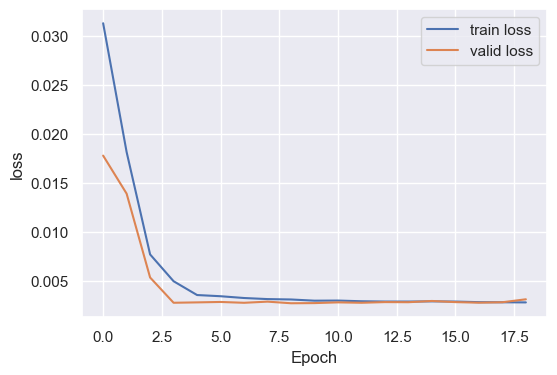

In [44]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

In [45]:
def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss, bins=40,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    #anomalies = threshold_test > threshold_train
    #print('\n')
    #print("Train Threshold Based Detected Anomalies: ", np.sum(anomalies))
    #print("Real Normal Labels from Test Data : ", y_test.value_counts()[0])
    #print("Real Fault Labels from Test Data : ", y_test.value_counts()[1])
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

18/18 [==============================] - 0s 1ms/step




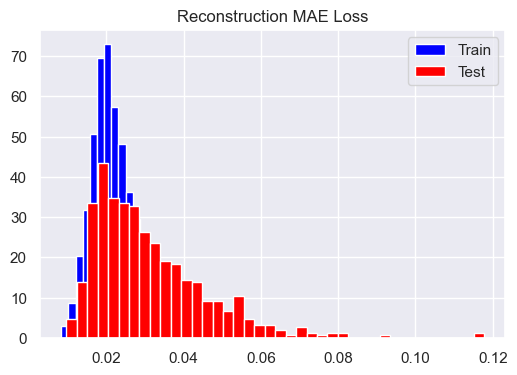



Train (Normal Only) Reconstruction error threshold: 0.08223780966959696


Test Reconstruction error threshold: 0.11775076738889645


In [46]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,X_train_Normal,X_test)

In [47]:
def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(X_test[:])
    test_score_df['loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['QUALITY']})

    plt.figure(figsize=(4, 3))
    plt.title(model, fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()

In [48]:
threshold_train

0.08223780966959696

Confusion Matrix
[[247  66]
 [ 47 204]]


정확도: 0.8 정밀도: 0.756 재현율: 0.813 AUC: 0.884 F1: 0.783 F2: 0.801 Balanced_Accuracy: 0.801


              precision    recall  f1-score   support

          양품       0.84      0.79      0.81       313
          불량       0.76      0.81      0.78       251

    accuracy                           0.80       564
   macro avg       0.80      0.80      0.80       564
weighted avg       0.80      0.80      0.80       564



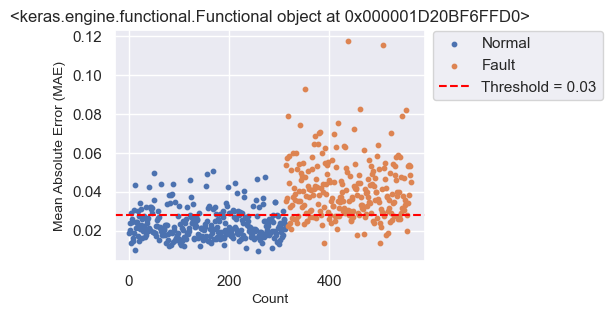

In [49]:
anomaly_threshold(threshold = 0.028, model=autoencoder)

In [50]:
#for i in range(0,len(test_mae_loss)):
    
    
#    anomaly_threshold(test_mae_loss[i],'Autoencoder')
#    print('threshold'+ ' = ' + str(test_mae_loss[i]))
#    print('-----------------------------------------------------------------------------------------')
#    print('\n')